### 1. Import libraries

In [19]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time seres
from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.tools import diff

# Model selection/Comparison
from pmdarima import auto_arima
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Metrics/Eval
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.eval_measures import aic, bic
import itertools

### 2. Load and Inspect Data

In [21]:
# Setting max display for df
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [22]:
# Reading excel file into df
raw_df = pd.read_excel('../data/Metro_Interstate_Traffic_Volume.xlsx')

In [23]:
# Selecting the variables for ARIMA forecasting
df = raw_df[['traffic_volume', 'date_time']]

In [24]:
# Check for nulls and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   traffic_volume  48204 non-null  int64         
 1   date_time       48204 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 753.3 KB


In [25]:
# Generate basic statistics for variables
df.describe()

traffic_volume                      date_time
count    48204.000000                          48204
mean      3259.818355  2016-01-05 10:46:16.773711616
min          0.000000            2012-10-02 09:00:00
25%       1193.000000            2014-02-06 11:45:00
50%       3380.000000            2016-06-11 03:30:00
75%       4933.000000            2017-08-11 06:00:00
max       7280.000000            2018-09-30 23:00:00
std       1986.860670                            NaN

In [26]:
# Check for duplicates
mask = df.duplicated(subset=['date_time'], keep=False)
dfmask = df[mask]

In [27]:
# Show index of duplicates
dfmask.head(20)

traffic_volume           date_time
178            6793 2012-10-10 07:00:00
179            6793 2012-10-10 07:00:00
180            6283 2012-10-10 08:00:00
181            6283 2012-10-10 08:00:00
182            5680 2012-10-10 09:00:00
183            5680 2012-10-10 09:00:00
269            2685 2012-10-14 09:00:00
270            2685 2012-10-14 09:00:00
271            2685 2012-10-14 09:00:00
272            3370 2012-10-14 10:00:00
273            3370 2012-10-14 10:00:00
274            3662 2012-10-14 11:00:00
275            3662 2012-10-14 11:00:00
276            4076 2012-10-14 12:00:00
277            4076 2012-10-14 12:00:00
278            4076 2012-10-14 12:00:00
279            4128 2012-10-14 13:00:00
280            4128 2012-10-14 13:00:00
281            4128 2012-10-14 13:00:00
282            4358 2012-10-14 14:00:00

In [28]:
df[170:300]

traffic_volume           date_time
170            2306 2012-10-09 21:00:00
171            1846 2012-10-09 22:00:00
172             947 2012-10-09 23:00:00
173             494 2012-10-10 00:00:00
174             332 2012-10-10 01:00:00
175             261 2012-10-10 02:00:00
176             361 2012-10-10 03:00:00
177            5875 2012-10-10 06:00:00
178            6793 2012-10-10 07:00:00
179            6793 2012-10-10 07:00:00
180            6283 2012-10-10 08:00:00
181            6283 2012-10-10 08:00:00
182            5680 2012-10-10 09:00:00
183            5680 2012-10-10 09:00:00
184            4632 2012-10-10 10:00:00
185            4887 2012-10-10 11:00:00
186            5030 2012-10-10 12:00:00
187            5067 2012-10-10 13:00:00
188            5227 2012-10-10 14:00:00
189            5610 2012-10-10 15:00:00
190            6286 2012-10-10 16:00:00
191            4775 2012-10-10 18:00:00
192            3340 2012-10-10 19:00:00
193            3013 2012-10-10 20:00:00
194            2603 2012-10-10 21:00:00
195            1910 2012-10-10 22:00:00
196            1037 2012-10-10 23:00:00
197             347 2012-10-11 01:00:00
198             350 2012-10-11 03:00:00
199             850 2012-10-11 04:00:00
200            2791 2012-10-11 05:00:00
201            5809 2012-10-11 06:00:00
202            6798 2012-10-11 07:00:00
203            6304 2012-10-11 08:00:00
204            5291 2012-10-11 09:00:00
205            4638 2012-10-11 10:00:00
206            5557 2012-10-11 14:00:00
207            5818 2012-10-11 15:00:00
208            6272 2012-10-11 16:00:00
209            5944 2012-10-11 17:00:00
210            4949 2012-10-11 18:00:00
211            3511 2012-10-11 19:00:00
212            3039 2012-10-11 20:00:00
213            2679 2012-10-11 21:00:00
214            2094 2012-10-11 22:00:00
215            1284 2012-10-11 23:00:00
216             630 2012-10-12 00:00:00
217             410 2012-10-12 01:00:00
218             331 2012-10-12 02:00:00
219             372 2012-10-12 03:00:00
220             739 2012-10-12 04:00:00
221            2561 2012-10-12 05:00:00
222            5586 2012-10-12 06:00:00
223            6992 2012-10-12 07:00:00
224            5860 2012-10-12 08:00:00
225            5230 2012-10-12 09:00:00
226            4864 2012-10-12 10:00:00
227            5146 2012-10-12 11:00:00
228            5526 2012-10-12 12:00:00
229            5383 2012-10-12 13:00:00
230            5758 2012-10-12 14:00:00
231            5889 2012-10-12 15:00:00
232            6057 2012-10-12 16:00:00
233            6028 2012-10-12 17:00:00
234            5257 2012-10-12 18:00:00
235            1897 2012-10-12 23:00:00
236            1335 2012-10-13 00:00:00
237             769 2012-10-13 01:00:00
238             570 2012-10-13 02:00:00
239             413 2012-10-13 03:00:00
240             399 2012-10-13 04:00:00
241             740 2012-10-13 05:00:00
242            1420 2012-10-13 06:00:00
243            2220 2012-10-13 07:00:00
244            3479 2012-10-13 08:00:00
245            4546 2012-10-13 09:00:00
246            4579 2012-10-13 10:00:00
247            4438 2012-10-13 11:00:00
248            4623 2012-10-13 12:00:00
249            4440 2012-10-13 13:00:00
250            4495 2012-10-13 14:00:00
251            4483 2012-10-13 15:00:00
252            4591 2012-10-13 16:00:00
253            4477 2012-10-13 17:00:00
254            4221 2012-10-13 18:00:00
255            3672 2012-10-13 19:00:00
256            3015 2012-10-13 20:00:00
257            2769 2012-10-13 21:00:00
258            2875 2012-10-13 22:00:00
259            1931 2012-10-13 23:00:00
260            1309 2012-10-14 00:00:00
261             870 2012-10-14 01:00:00
262             654 2012-10-14 02:00:00
263             364 2012-10-14 03:00:00
264             262 2012-10-14 04:00:00
265             505 2012-10-14 05:00:00
266             861 2012-10-14 06:00:00
267            1132 2012-10-14 07:00:00
268            1797 2012-10-14 08:00:00
269  

In [29]:
# Remove duplicates
df = df.drop_duplicates(keep='first')

In [30]:
# Around 8k duplicates removed
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40575 entries, 0 to 48203
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   traffic_volume  40575 non-null  int64         
 1   date_time       40575 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 951.0 KB


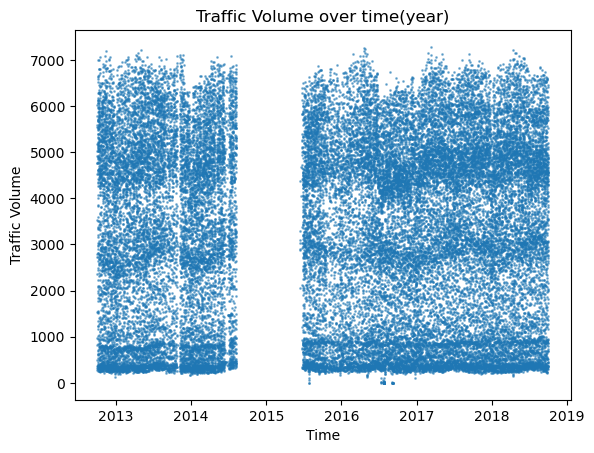

In [31]:
# Plot traffic volume against time(year)
plt.title("Traffic Volume over time(year)")
plt.scatter(df.date_time, df.traffic_volume, alpha=0.5, s=1)
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.show()

In [33]:
df = df.set_index('date_time')

In [34]:
hourly = df['traffic_volume'].resample('h').mean()
daily = df['traffic_volume'].resample('d').mean()
monthly = df['traffic_volume'].resample('m').mean()

C:\Users\User\AppData\Local\Temp\ipykernel_26888\3045724864.py:3: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df['traffic_volume'].resample('m').mean()


In [41]:
df

traffic_volume
date_time                          
2012-10-02 09:00:00            5545
2012-10-02 10:00:00            4516
2012-10-02 11:00:00            4767
2012-10-02 12:00:00            5026
2012-10-02 13:00:00            4918
2012-10-02 14:00:00            5181
2012-10-02 15:00:00            5584
2012-10-02 16:00:00            6015
2012-10-02 17:00:00            5791
2012-10-02 18:00:00            4770
2012-10-02 19:00:00            3539
2012-10-02 20:00:00            2784
2012-10-02 21:00:00            2361
2012-10-02 22:00:00            1529
2012-10-02 23:00:00             963
2012-10-03 00:00:00             506
2012-10-03 01:00:00             321
2012-10-03 02:00:00             273
2012-10-03 03:00:00             367
2012-10-03 04:00:00             814
2012-10-03 05:00:00            2718
2012-10-03 06:00:00            5673
2012-10-03 08:00:00            6511
2012-10-03 09:00:00            5471
2012-10-03 12:00:00            5097
2012-10-03 13:00:00            4887
2012-10-03 14:00:00            5337
2012-10-03 15:00:00            5692
2012-10-03 16:00:00            6137
2012-10-03 18:00:00            4623
2012-10-03 19:00:00            3591
2012-10-03 20:00:00            2898
2012-10-03 21:00:00            2637
2012-10-03 22:00:00            1777
2012-10-03 23:00:00            1015
2012-10-04 00:00:00             598
2012-10-04 01:00:00             369
2012-10-04 02:00:00             312
2012-10-04 03:00:00             367
2012-10-04 04:00:00             835
2012-10-04 05:00:00            2726
2012-10-04 06:00:00            5689
2012-10-04 07:00:00            6990
2012-10-04 08:00:00            5985
2012-10-04 09:00:00            5309
2012-10-04 10:00:00            4603
2012-10-04 11:00:00            4884
2012-10-04 12:00:00            5104
2012-10-04 13:00:00            5178
2012-10-04 14:00:00            5501
2012-10-04 15:00:00            5713
2012-10-04 16:00:00            6292
2012-10-04 17:00:00            6057
2012-10-04 18:00:00            4907
2012-10-04 19:00:00            3503
2012-10-04 20:00:00            3037
2012-10-04 21:00:00            2822
2012-10-04 22:00:00            1992
2012-10-04 23:00:00            1166
2012-10-05 00:00:00             627
2012-10-05 01:00:00             388
2012-10-05 03:00:00             368
2012-10-05 05:00:00            2489
2012-10-05 06:00:00            5537
2012-10-05 07:00:00            6628
2012-10-05 08:00:00            5534
2012-10-05 09:00:00            5403
2012-10-05 10:00:00            4770
2012-10-05 11:00:00            5217
2012-10-05 12:00:00            5870
2012-10-05 13:00:00            5967
2012-10-05 14:00:00            6108
2012-10-05 15:00:00            6128
2012-10-05 16:00:00            6069
2012-10-05 17:00:00            6169
2012-10-05 18:00:00            5384
2012-10-05 19:00:00            4063
2012-10-05 20:00:00            3364
2012-10-05 21:00:00            2971
2012-10-05 22:00:00            2450
2012-10-05 23:00:00            1832
2012-10-06 00:00:00            1231
2012-10-06 01:00:00             718
2012-10-06 02:00:00             545
2012-10-06 04:00:00             411
2012-10-06 05:00:00             688
2012-10-06 06:00:00            1352
2012-10-06 07:00:00            2072
2012-10-06 08:00:00            3342
2012-10-06 09:00:00            4258
2012-10-06 10:00:00            4861
2012-10-06 11:00:00            5191
2012-10-06 12:00:00            5669
2012-10-06 13:00:00            5074
2012-10-06 14:00:00            5025
2012-10-06 15:00:00            5153
2012-10-06 16:00:00            5024
2012-10-06 17:00:00            4779
2012-10-06 18:00:00            4362
2012-10-06 19:00:00            3860
2012-10-06 20:00:00            3160
2012-10-06 21:00:00            2992
2012-10-06 22:00:00            3202
2012-10-06 23:00:00            1941
2012-10-07 00:00:00            1233
2012-10-07 03:00:00             323
2012-10-07 04:00:00             312
2012-10-07 05:00:00             627
2012-10-07 06:00:00            1508
2012-10-07 07:00:00      

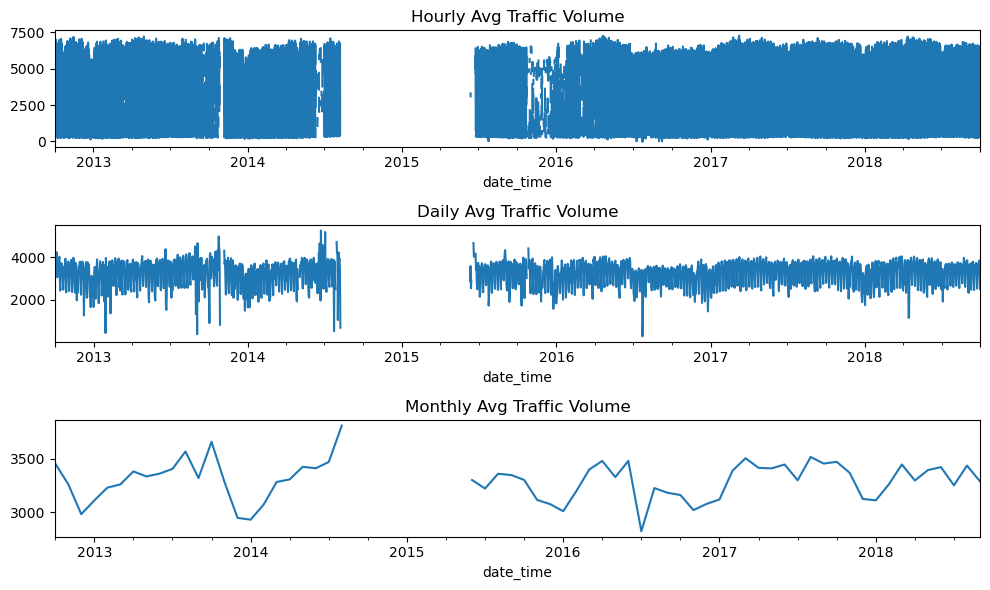

In [40]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6))
hourly.plot(ax=ax[0], title='Hourly Avg Traffic Volume')
daily.plot(ax=ax[1], title='Daily Avg Traffic Volume')
monthly.plot(ax=ax[2], title='Monthly Avg Traffic Volume')
plt.tight_layout()
plt.show()

We must take note of the missing data between the dates: 2014-08-08 01:00:00 to 2015-06-11 20:00:00

10 months of missing data may impact the precision of our forecast. We may have to interpolate the missing months with the cost of added synthetic variance that may distort long-term forecasting or cut out and do our analysis on the longest continous block of data.

Using the more recent continuous block of data (starting mid 2016) could be more informative for short-midterm forecasting and ensures more reliability within that scope.

### 3. Preprocessing

### 4. Exploratory Plots

### 5. Check Stationarity

### 6. ACF/PACF Analysis

### 7. Fit ARIMA Model

### 8. Forecast

### 9. Evaluation